In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**H1** In 2014, a paper was published that was entitled *“Female hurricanes are deadlier than male hurricanes.”* As the title suggests, the paper claimed that hurricanes with female names have caused greater loss of life, and the explanation given is that people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate. Statisticians severely criticized the paper after publication. Here, you’ll explore the complete data used in the paper and consider the hypothesis that hurricanes with female names are deadlier. Load
the data from `Hurricanes`. 

In this problem, you’ll focus on predicting deaths using femininity of each hurricane’s name. Fit and interpret the simplest possible model, a Poisson model of deaths using femininity as a predictor. Compare the model to an intercept-only Poisson model of deaths. How strong is the association between femininity of name and deaths? Which storms does the model fit (retrodict) well? Which storms does it fit poorly?

In [8]:
data = pd.read_csv('../data/Hurricanes.csv', sep=';')
data = data.drop('female', axis=1)
data.sample(5)

,name,year,deaths,category,min_pressure,damage_norm,femininity
89,Irene,2011,41,1,952,7110,9.27778
71,Lili,2002,2,1,963,1260,10.33333
1,King,1950,4,3,955,5350,1.38889
27,Gladys,1968,3,2,977,800,8.94444
23,Betsy,1965,75,3,948,20000,8.33333


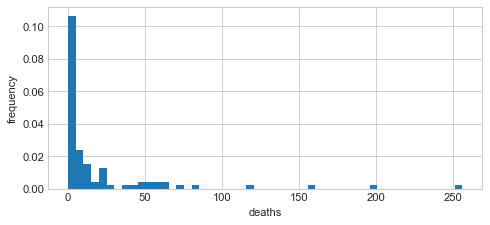

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=80)
ax.hist(data.deaths, bins=51, density=True)
ax.set(xlabel='deaths', ylabel='frequency')
None

In [5]:
with pm.Model() as m_basic:

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())

    deaths_obs = pm.Poisson('deaths_obs', mu=alpha,
                            observed=data.deaths.values)

    m_basic.name = 'basic'
    m_basic.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1883.42draws/s]


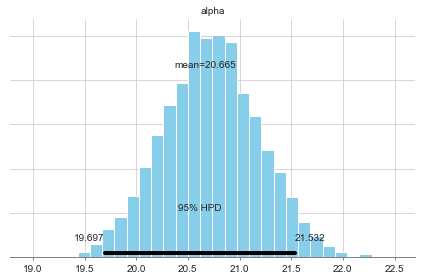

In [6]:
pm.plot_posterior(m_basic.trace)
None

In [11]:
with pm.Model() as m_fem:
    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem = pm.Normal('beta_fem', mu=0, sd=10)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(beta_fem * data.femininity.values)
    )

    deaths_obs = pm.Poisson('deaths_obs', mu=deaths,
                            observed=data.deaths.values)

    m_fem.name = 'femininity'
    m_fem.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:13<00:00, 877.24draws/s]
The acceptance probability does not match the target. It is 0.8883184243044704, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


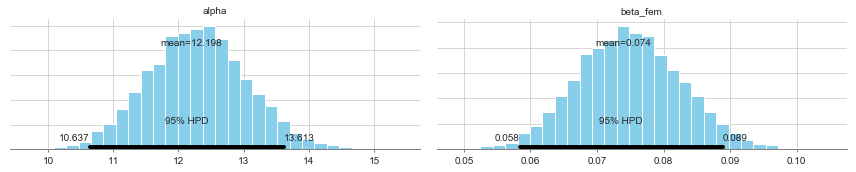

In [14]:
pm.plot_posterior(m_fem.trace, varnames=['alpha', 'beta_fem'])
None

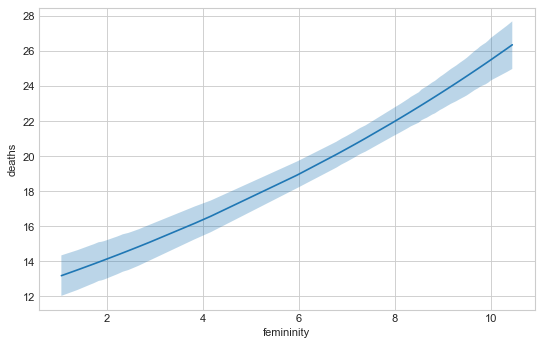

In [27]:
tmp = agg_prediction(m_fem.trace['deaths'], data, ['femininity'], summarize(.11))
tmp = tmp.sort_values('femininity')

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.plot(tmp.femininity, tmp.mean_)
ax.fill_between(tmp.femininity, tmp.lower, tmp.upper,
                alpha=.3)
ax.set(xlabel='femininity', ylabel='deaths')
None

In [26]:
tmp = agg_prediction(m_fem.trace['deaths'], data, ['femininity'], summarize())

tmp = pd.merge(data, tmp[['mean_', 'femininity']], how='inner', on='femininity')

tmp = tmp.assign(diff_ = tmp.deaths - tmp.mean_)
tmp = tmp.assign(abs_diff = np.abs(tmp.diff_))
tmp = tmp.sort_values('abs_diff').reset_index(drop=True)
tmp = tmp.drop(['abs_diff', 'diff_'], axis=1)

pd.concat([tmp.iloc[:6], tmp.iloc[-6:]])[['name', 'femininity', 'deaths', 'mean_']]

,name,femininity,deaths,mean_
0,Dennis,2.44444,15,14.599439
1,David,1.72222,15,13.843873
2,Bob,1.66667,15,13.787422
3,Juan,1.94444,12,14.072044
4,Celia,9.44444,22,24.476166
5,Eloise,8.94444,21,23.586898
86,Betsy,8.33333,75,22.544246
87,Ike,1.88889,84,14.014652
88,Agnes,8.66667,117,23.107064
89,Sandy,9.00000,159,23.684078


**H2** Counts are nearly always over-dispersed relative to Poisson. So fit a gamma-Poisson (aka negative-binomial) model to predict deaths using femininity. Show that the over-dispersed model no longer shows as precise a positive association between femininity and deaths, with an 89% interval that overlaps zero. Can you explain why the association diminished in strength?


In [28]:
with pm.Model() as m_neg_bin:
    p = pm.Exponential('p', lam=1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem = pm.Normal('beta_fem', mu=0, sd=10)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(beta_fem * data.femininity.values)
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_neg_bin.name = 'negative binomial'
    m_neg_bin.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, beta_fem, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:19<00:00, 607.29draws/s]


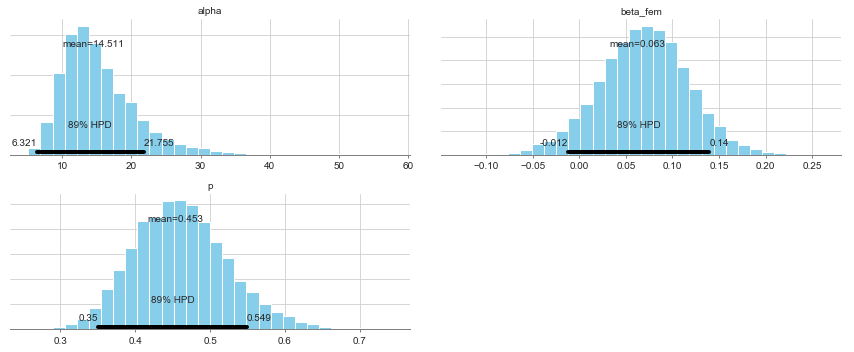

In [31]:
pm.plot_posterior(m_neg_bin.trace, varnames=['alpha', 'beta_fem', 'p'], alpha_level=.11)
None

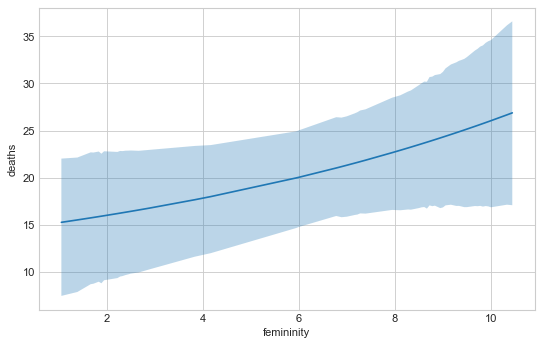

In [30]:
tmp = agg_prediction(m_neg_bin.trace['deaths'], data, ['femininity'], summarize(.11))
tmp = tmp.sort_values('femininity')

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.plot(tmp.femininity, tmp.mean_)
ax.fill_between(tmp.femininity, tmp.lower, tmp.upper,
                alpha=.3)
ax.set(xlabel='femininity', ylabel='deaths')
None

**H3** In order to infer a strong association between deaths and femininity, it’s necessary to include an interaction effect. In the data, there are two measures of a hurricane’s potential to cause death:

- `damage_norm`: Normalized estimate of damage in dollars
- `min_pressure` : Minimum pressure, a measure of storm strength; low is stronger

It makes some sense to imagine that femininity of a name matters more when the hurricane is itself deadly. This implies an interaction between femininity and either or both of damage_norm and min_pressure. Fit a series of models evaluating these interactions. Interpret and compare the models. In interpreting the estimates, it may help to generate counterfactual predictions contrasting hurricanes with masculine and feminine names. Are the effect sizes plausible?


In [32]:
data = data.assign(
    min_pressure_sc = ( data.min_pressure - data.min_pressure.mean() ) / data.min_pressure.std(),
    damage_sc = data.damage_norm / data.damage_norm.max(),
)

data.head(5)

,name,year,deaths,category,min_pressure,damage_norm,femininity,min_pressure_sc,damage_sc
0,Easy,1950,2,3,960,1590,6.77778,-0.257695,0.021200
1,King,1950,4,3,955,5350,1.38889,-0.519951,0.071333
2,Able,1952,3,1,985,150,3.83333,1.053585,0.002000
3,Barbara,1953,1,1,987,58,9.83333,1.158488,0.000773
4,Florence,1953,0,1,985,15,8.33333,1.053585,0.000200


In [34]:
with pm.Model() as m_h3_1:
    p = pm.Exponential('p', lam=1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem = pm.Normal('beta_fem', mu=0, sd=1)
    beta_damage = pm.Normal('beta_damage', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_fem * data.femininity.values
            + beta_damage * data.damage_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_1.name = 'fem & damage'
    m_h3_1.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_damage, beta_fem, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:21<00:00, 553.22draws/s]


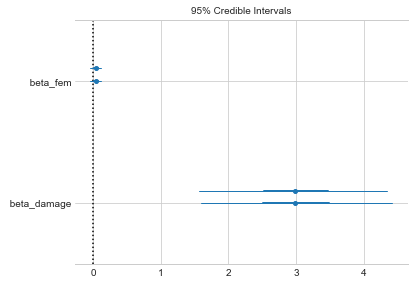

In [39]:
pm.forestplot(m_h3_1.trace, varnames=['beta_fem', 'beta_damage'], rhat=False)
None

In [36]:
with pm.Model() as m_h3_2:
    p = pm.Exponential('p', lam = 1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem = pm.Normal('beta_fem', mu=0, sd=1)
    beta_damage = pm.Normal('beta_damage', mu=0, sd=1)
    beta_fem_damage = pm.Normal('beta_fem_damage', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_fem * data.femininity.values
            + beta_damage * data.damage_sc.values
            + beta_fem_damage * data.femininity.values * data.damage_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_2.name = 'fem vs damage'
    m_h3_2.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_damage, beta_damage, beta_fem, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:26<00:00, 461.00draws/s]


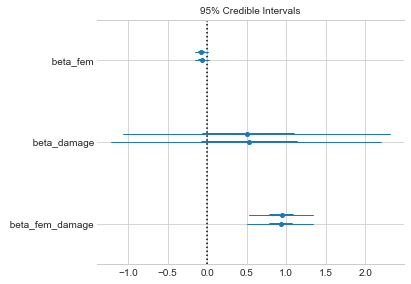

In [38]:
pm.forestplot(m_h3_2.trace,
              varnames=['beta_fem', 'beta_damage', 'beta_fem_damage'],
              rhat=False)
None

In [42]:
with pm.Model() as m_h3_3:
    p = pm.Exponential('p', lam = 1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_damage = pm.Normal('beta_damage', mu=0, sd=1)
    beta_fem_damage = pm.Normal('beta_fem_damage', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_damage * data.damage_sc.values
            + beta_fem_damage * data.femininity.values * data.damage_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_3.name = 'fem vs damage, v2'
    m_h3_3.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_damage, beta_damage, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:15<00:00, 770.77draws/s]


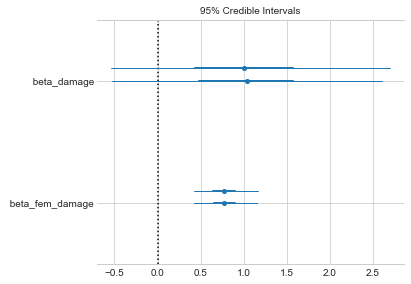

In [44]:
pm.forestplot(m_h3_3.trace,
              varnames=['beta_damage', 'beta_fem_damage'],
              rhat=False)
None

In [50]:
with pm.Model() as m_h3_4:
    p = pm.Exponential('p', lam=1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem = pm.Normal('beta_fem', mu=0, sd=1)
    beta_pressure = pm.Normal('beta_pressure', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_fem * data.femininity.values
            + beta_pressure * data.min_pressure_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_4.name = 'fem & pressure'
    m_h3_4.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_pressure, beta_fem, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:21<00:00, 548.12draws/s]


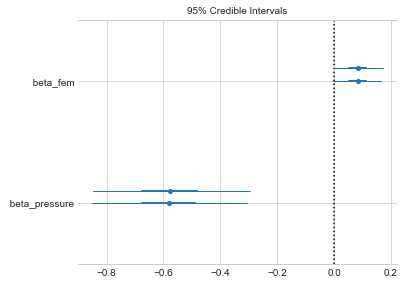

In [51]:
pm.forestplot(m_h3_4.trace,
              varnames=['beta_fem', 'beta_pressure'],
              rhat=False)
None

In [53]:
with pm.Model() as m_h3_5:
    p = pm.Exponential('p', lam=1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem = pm.Normal('beta_fem', mu=0, sd=1)
    beta_pressure = pm.Normal('beta_pressure', mu=0, sd=1)
    beta_fem_pressure = pm.Normal('beta_fem_pressure', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_fem * data.femininity.values
            + beta_pressure * data.min_pressure_sc.values
            + beta_fem_pressure * data.femininity.values * data.min_pressure_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_5.name = 'fem vs. pressure'
    m_h3_5.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_pressure, beta_pressure, beta_fem, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:28<00:00, 421.19draws/s]


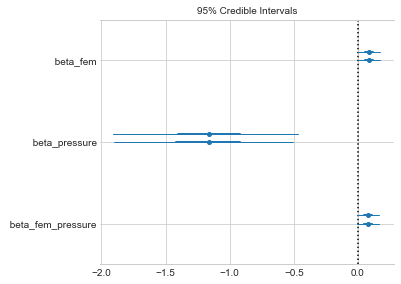

In [55]:
pm.forestplot(m_h3_5.trace,
              varnames=['beta_fem', 'beta_pressure', 'beta_fem_pressure'],
              rhat=False)
None

In [57]:
with pm.Model() as m_h3_6:
    p = pm.Exponential('p', lam=1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_pressure = pm.Normal('beta_pressure', mu=0, sd=1)
    beta_fem_pressure = pm.Normal('beta_fem_pressure', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_pressure * data.min_pressure_sc.values
            + beta_fem_pressure * data.femininity.values * data.min_pressure_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_6.name = 'fem vs pressure, v2'
    m_h3_6.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_pressure, beta_pressure, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:26<00:00, 445.41draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


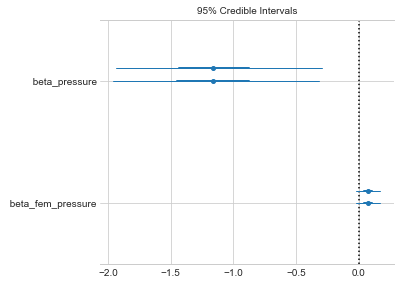

In [59]:
pm.forestplot(m_h3_6.trace,
              varnames=['beta_pressure', 'beta_fem_pressure'],
              rhat=False)
None

In [65]:
with pm.Model() as m_h3_7:
    p = pm.Exponential('p', lam = 1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_damage = pm.Normal('beta_damage', mu=0, sd=1)
    beta_fem_damage = pm.Normal('beta_fem_damage', mu=0, sd=1)
    beta_pressure = pm.Normal('beta_pressure', mu=0, sd=1)
    beta_fem_pressure = pm.Normal('beta_fem_pressure', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_damage * data.damage_sc.values
            + beta_fem_damage * data.femininity.values * data.damage_sc.values
            + beta_pressure * data.min_pressure_sc.values
            + beta_fem_pressure * data.femininity.values * data.min_pressure_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_7.name = 'fem vs damage, fem vs presure'
    m_h3_7.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_pressure, beta_pressure, beta_fem_damage, beta_damage, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:29<00:00, 401.28draws/s]


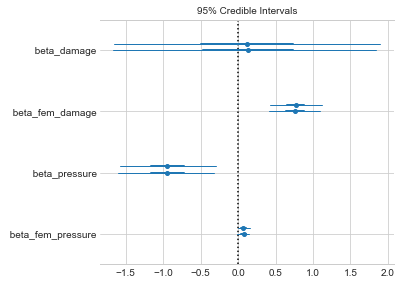

In [68]:
pm.forestplot(m_h3_7.trace,
              varnames=['beta_damage', 'beta_fem_damage', 'beta_pressure', 'beta_fem_pressure'],
              rhat=False)
None

In [69]:
with pm.Model() as m_h3_8:
    p = pm.Exponential('p', lam = 1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem_damage = pm.Normal('beta_fem_damage', mu=0, sd=1)
    beta_pressure = pm.Normal('beta_pressure', mu=0, sd=1)
    beta_fem_pressure = pm.Normal('beta_fem_pressure', mu=0, sd=1)

    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_fem_damage * data.femininity.values * data.damage_sc.values
            + beta_pressure * data.min_pressure_sc.values
            + beta_fem_pressure * data.femininity.values * data.min_pressure_sc.values
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h3_8.name = 'fem vs damage, fem vs presure, v2'
    m_h3_8.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_pressure, beta_pressure, beta_fem_damage, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:26<00:00, 460.95draws/s]


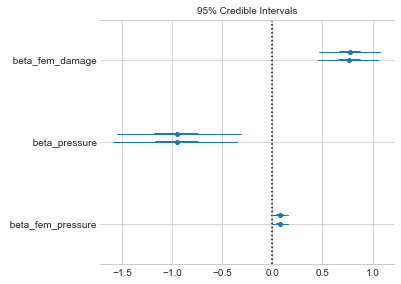

In [73]:
pm.forestplot(m_h3_8.trace,
              varnames=['beta_fem_damage', 'beta_pressure', 'beta_fem_pressure'],
              rhat=False)
None

In [82]:
comparison = pm.compare({
        m_neg_bin: m_neg_bin.trace,
        m_h3_1: m_h3_1.trace,
        m_h3_2: m_h3_2.trace,
        m_h3_3: m_h3_3.trace,
        m_h3_4: m_h3_4.trace,
        m_h3_5: m_h3_5.trace,
        m_h3_6: m_h3_6.trace,
        m_h3_7: m_h3_7.trace,
        m_h3_8: m_h3_8.trace,
    },
    method='BB-pseudo-BMA',
)

comparison

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
"fem vs damage, fem vs presure, v2",662.4,7.3,0,0.39,35.05,0,1
"fem vs damage, fem vs presure",662.71,7.45,0.3,0.34,35.12,0.22,1
"fem vs damage, v2",668.89,4.42,6.48,0.12,32.33,8.7,1
fem vs damage,669.01,5.37,6.61,0.11,33.08,8.51,1
fem & damage,680.57,3.88,18.17,0.04,30.96,11.08,1
fem vs. pressure,694.61,8.41,32.2,0,38.88,12.61,1
fem & pressure,697.99,8.47,35.58,0,41.15,15.15,1
"fem vs pressure, v2",698.28,8.57,35.88,0,41.98,15.9,1
negative binomial,709.42,3.49,47.01,0,30.88,11.93,1


In [102]:
test = pd.DataFrame(
    [[fem, min_pressure_sc, damage_sc]
     for fem in np.linspace(0, 10, 11)
     for min_pressure_sc in (-1, 0, 1)
     for damage_sc in (0, .5, 1)],
    columns=['femininity', 'min_pressure_sc', 'damage_sc']
)
test.head(5)

,femininity,min_pressure_sc,damage_sc
0,0.0,-1,0.0
1,0.0,-1,0.5
2,0.0,-1,1.0
3,0.0,0,0.0
4,0.0,0,0.5


In [104]:
with pm.Model() as m_h3_8_test:
    p = pm.Exponential('p', lam = 1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_fem_damage = pm.Normal('beta_fem_damage', mu=0, sd=1)
    beta_pressure = pm.Normal('beta_pressure', mu=0, sd=1)
    beta_fem_pressure = pm.Normal('beta_fem_pressure', mu=0, sd=1)

    def get_deaths(df):
        return alpha * pm.math.exp(
            beta_fem_damage * df.femininity.values * df.damage_sc.values
            + beta_pressure * df.min_pressure_sc.values
            + beta_fem_pressure * df.femininity.values * df.min_pressure_sc.values
        )
    
    deaths = pm.Deterministic('deaths', get_deaths(data))

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    deaths_test = pm.Deterministic('deaths_test', get_deaths(test))
    
    m_h3_8_test.name = 'fem vs damage, fem vs presure, v2 test'
    m_h3_8_test.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_pressure, beta_pressure, beta_fem_damage, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:25<00:00, 469.31draws/s]


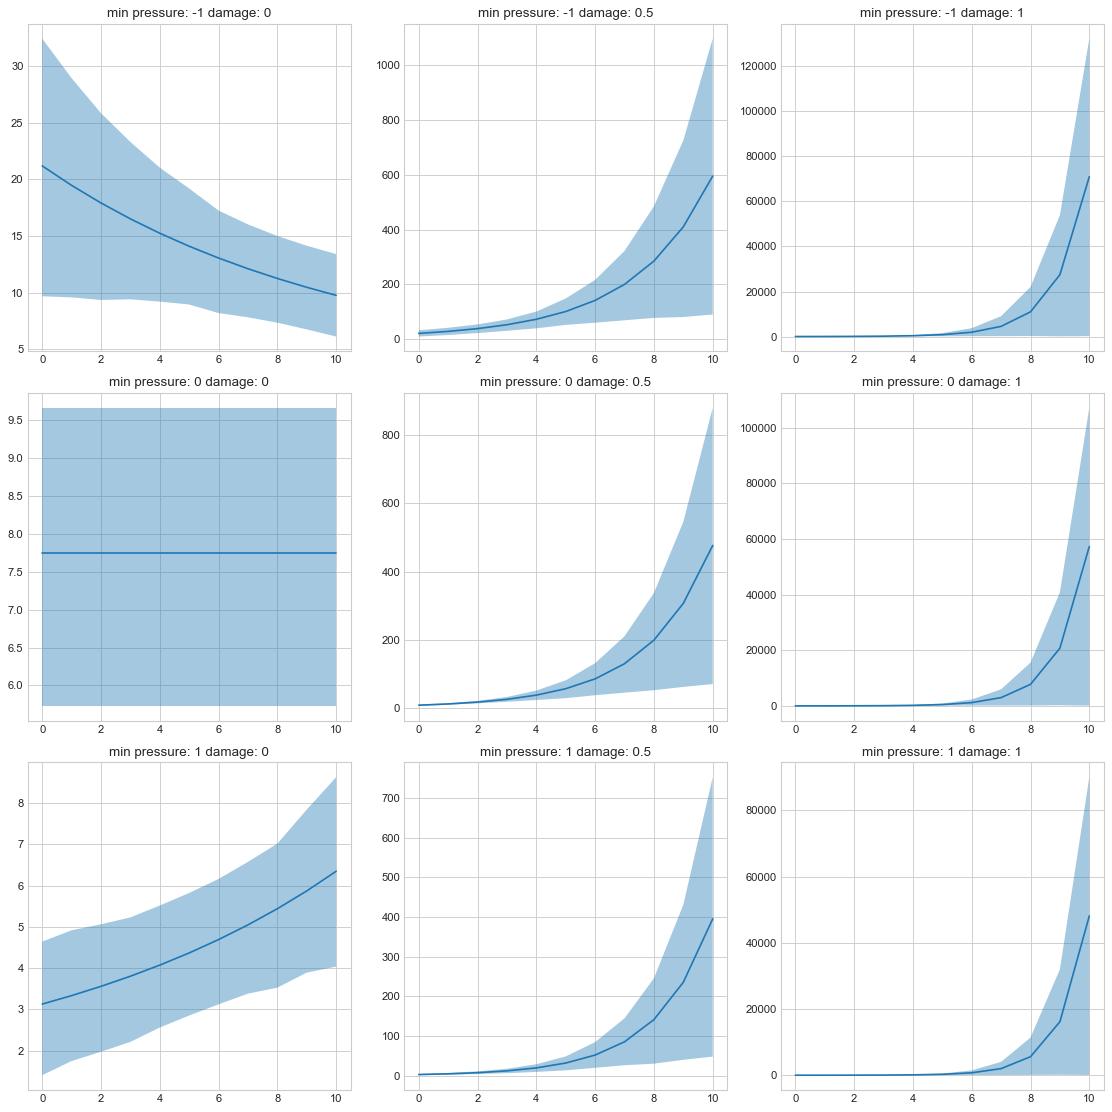

In [118]:
tmp = agg_prediction(m_h3_8_test.trace['deaths_test'], test,
                     ['femininity', 'min_pressure_sc', 'damage_sc'], summarize(.11))
tmp = tmp.sort_values('femininity')

fig, axes = plt.subplots(3, 3, figsize=(14, 14), dpi=80)

for axrow, min_pressure_sc in zip(axes, (-1, 0, 1)):
    for ax, damage_sc in zip(axrow, (0, 0.5, 1)):
        sub_tmp = tmp[(tmp.min_pressure_sc == min_pressure_sc)
                      & (tmp.damage_sc == damage_sc)]
        
        ax.plot(sub_tmp.femininity, sub_tmp.mean_)
        ax.fill_between(sub_tmp.femininity, sub_tmp.lower, sub_tmp.upper,
                        alpha=.4)
        
        ax.set(title=f'min pressure: {min_pressure_sc} damage: {damage_sc}')

fig.tight_layout()        
None

**H4** In the original hurricanes paper, storm damage (`damage_norm`) was used directly. This assumption implies that mortality increases exponentially with a linear increase in storm strength, because a Poisson regression uses a log link. So it’s worth exploring an alternative hypothesis: that the logarithm of storm strength is what matters. Explore this by using the logarithm of `damage_norm` as a predictor. Using the best model structure from the previous problem, compare a model that uses `log(damage_norm)` to a model that uses `damage_norm` directly. Compare their DIC/WAIC values as well as their implied predictions. What do you conclude?

In [127]:
with pm.Model() as m_h4:
    p = pm.Exponential('p', lam = 1)

    alpha = pm.Exponential('alpha', lam = 1/data.deaths.mean())
    beta_damage = pm.Normal('beta_damage', mu=0, sd=1)
    beta_fem_damage = pm.Normal('beta_fem_damage', mu=0, sd=1)

    log_damage = np.log(data.damage_sc.values) / 10
    
    deaths = pm.Deterministic(
        'deaths',
        alpha * pm.math.exp(
            beta_damage * log_damage
            + beta_fem_damage * (data.femininity.values * log_damage)
        )
    )

    deaths_obs = pm.NegativeBinomial(
        'deaths_obs', mu=deaths, alpha=p,
        observed=data.deaths.values)

    m_h4.name = 'fem vs log damage'
    m_h4.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fem_damage, beta_damage, alpha, p]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:22<00:00, 536.45draws/s]


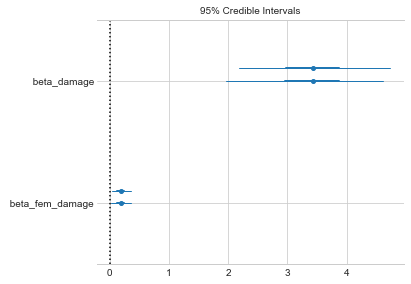

In [131]:
pm.forestplot(m_h4.trace,
              varnames=['beta_damage', 'beta_fem_damage'],
              rhat=False)
None

In [132]:
comparison = pm.compare({
        m_h4: m_h4.trace,
        m_h3_3: m_h3_3.trace,
    },
    method='BB-pseudo-BMA',
)

comparison

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
fem vs log damage,639.37,3.8,0,0.97,32.82,0,1
"fem vs damage, v2",668.89,4.42,29.52,0.03,32.18,14.24,1
